# Support_Vector_Machine_Classifier

## I. Chuẩn bị dữ liệu

In [76]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

df = pd.read_csv('../Dataset/archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')

X = df.drop(['Attrition', 'EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1)
y = df['Attrition']

col_int32 = ['DailyRate', 'MonthlyIncome', 'MonthlyRate']
col_int16 = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
             'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 
             'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 
             'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
             'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
             'YearsSinceLastPromotion', 'YearsWithCurrManager']

# ép kiểu
X[col_int32] = X[col_int32].astype('int32')
X[col_int16] = X[col_int16].astype('int16')

X_origin = X.copy()
y_origin = y.copy()

# One-hot cho các cột nominal
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

encode_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'OverTime'
]

X_encoded_array = one_hot_encoder.fit_transform(X_origin[encode_cols])
encoded_columns = one_hot_encoder.get_feature_names_out(encode_cols)

X_encoded_df = pd.DataFrame(
    X_encoded_array, 
    columns=encoded_columns,
    index=X_origin.index
)

# Gộp data sau one-hot
X_encode = pd.concat([X_origin.drop(columns=encode_cols), X_encoded_df], axis=1)

# Encode y
label_encoder = LabelEncoder()
y_encode = label_encoder.fit_transform(y_origin)

# One-hot columns cũng ép về float32
one_hot_cols = X_encoded_df.columns
X_encode[one_hot_cols] = X_encode[one_hot_cols].astype('float32')


In [77]:
print(X_encode.shape)

(1470, 44)


In [78]:
X_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   int16  
 1   DailyRate                          1470 non-null   int32  
 2   DistanceFromHome                   1470 non-null   int16  
 3   Education                          1470 non-null   int16  
 4   EnvironmentSatisfaction            1470 non-null   int16  
 5   HourlyRate                         1470 non-null   int16  
 6   JobInvolvement                     1470 non-null   int16  
 7   JobLevel                           1470 non-null   int16  
 8   JobSatisfaction                    1470 non-null   int16  
 9   MonthlyIncome                      1470 non-null   int32  
 10  MonthlyRate                        1470 non-null   int32  
 11  NumCompaniesWorked                 1470 non-null   int16

In [79]:
X_encode

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1466,39,613,6,1,4,42,2,3,1,9991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1467,27,155,4,3,2,87,4,2,2,6142,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1468,49,1023,2,3,4,63,2,2,2,5390,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [80]:
# Đưa về nhãn -1 và 1 cho SVM
y_encode = np.where(y_encode == 0, -1, 1)
y_encode

array([ 1, -1,  1, ..., -1, -1, -1], shape=(1470,))

## II.Định nghĩa Class, Function hỗ trợ

In [81]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np

def auto_test_sklearn(X_train, X_test, y_train, y_test,
                      model,
                      sca=True,
                      reduce_name=None,
                      use_smote=False,
                      command='Default command'):

    print("=" * 60)
    print(f"Running test: {command}")

    # Scale continuous data
    if sca:
        continuous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount',
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
        ]
        cont_cols = [col for col in continuous_data if col in X_train.columns]

        scaler = StandardScaler()
        X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
        X_test[cont_cols] = scaler.transform(X_test[cont_cols])

    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    # Dimensionality Reduction
    if reduce_name == 'PCA':
        model_rd = PCA(n_components=6)
        X_train = model_rd.fit_transform(X_train)
        X_test = model_rd.transform(X_test)
    elif reduce_name == 'LDA':
        model_rd = LDA(n_components=1)
        X_train = model_rd.fit_transform(X_train, y_train)
        X_test = model_rd.transform(X_test)    

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    print("-" * 60)

    # Support vectors (sklearn)
    if hasattr(model, "support_"):
        print(f"Support Vectors: {len(model.support_)}")

    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test  Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))

    print("=" * 60 + "\n")


## III.Dự đoán với mô hình

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_copy_encode, y_copy_encode = X_encode.copy(), y_encode.copy()

### Thực hiện với dữ liệu đã mã hóa onehot và chuẩn hóa

#### 1.Thử nghiệm SVM với linear kernel C = (0.1; 1; 100) và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [83]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    command="Linear SVM (C=0.1), train/test=4/1"
)


Running test: Linear SVM (C=0.1), train/test=4/1


------------------------------------------------------------
Support Vectors: 391
Train Accuracy: 0.8929
Test  Accuracy: 0.9048

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.99      0.95       255
           1       0.82      0.36      0.50        39

    accuracy                           0.90       294
   macro avg       0.87      0.67      0.72       294
weighted avg       0.90      0.90      0.89       294

Confusion Matrix:
[[252   3]
 [ 25  14]]



In [84]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=1.0),
    sca=True,
    command="Linear SVM (C=1), train/test=4/1"
)


Running test: Linear SVM (C=1), train/test=4/1
------------------------------------------------------------
Support Vectors: 359
Train Accuracy: 0.8929
Test  Accuracy: 0.8878

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.96      0.94       255
           1       0.62      0.41      0.49        39

    accuracy                           0.89       294
   macro avg       0.76      0.69      0.71       294
weighted avg       0.87      0.89      0.88       294

Confusion Matrix:
[[245  10]
 [ 23  16]]



In [85]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=100.0),
    sca=True,
    command="Linear SVM (C=100), train/test=4/1"
)


Running test: Linear SVM (C=100), train/test=4/1
------------------------------------------------------------
Support Vectors: 357
Train Accuracy: 0.8954
Test  Accuracy: 0.8844

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.96      0.94       255
           1       0.60      0.38      0.47        39

    accuracy                           0.88       294
   macro avg       0.76      0.67      0.70       294
weighted avg       0.87      0.88      0.87       294

Confusion Matrix:
[[245  10]
 [ 24  15]]



In [86]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    command="Linear SVM (C=0.1), train/test=7/3"
)


Running test: Linear SVM (C=0.1), train/test=7/3
------------------------------------------------------------
Support Vectors: 347
Train Accuracy: 0.8902
Test  Accuracy: 0.8934

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.99      0.94       380
           1       0.85      0.28      0.42        61

    accuracy                           0.89       441
   macro avg       0.87      0.64      0.68       441
weighted avg       0.89      0.89      0.87       441

Confusion Matrix:
[[377   3]
 [ 44  17]]



In [87]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=1.0),
    sca=True,
    command="Linear SVM (C=1), train/test=7/3"
)


Running test: Linear SVM (C=1), train/test=7/3
------------------------------------------------------------
Support Vectors: 319
Train Accuracy: 0.8989
Test  Accuracy: 0.8934

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.98      0.94       380
           1       0.72      0.38      0.49        61

    accuracy                           0.89       441
   macro avg       0.81      0.68      0.72       441
weighted avg       0.88      0.89      0.88       441

Confusion Matrix:
[[371   9]
 [ 38  23]]



In [88]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=100.0),
    sca=True,
    command="Linear SVM (C=100), train/test=7/3"
)


Running test: Linear SVM (C=100), train/test=7/3
------------------------------------------------------------
Support Vectors: 311
Train Accuracy: 0.8950
Test  Accuracy: 0.8889

Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.97      0.94       380
           1       0.68      0.38      0.48        61

    accuracy                           0.89       441
   macro avg       0.79      0.67      0.71       441
weighted avg       0.87      0.89      0.88       441

Confusion Matrix:
[[369  11]
 [ 38  23]]



In [89]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    command="Linear SVM (C=0.1), train/test=6/4"
)


Running test: Linear SVM (C=0.1), train/test=6/4
------------------------------------------------------------
Support Vectors: 309
Train Accuracy: 0.8878
Test  Accuracy: 0.8929

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.99      0.94       507
           1       0.85      0.27      0.41        81

    accuracy                           0.89       588
   macro avg       0.87      0.63      0.68       588
weighted avg       0.89      0.89      0.87       588

Confusion Matrix:
[[503   4]
 [ 59  22]]



In [90]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=1.0),
    sca=True,
    command="Linear SVM (C=1), train/test=6/4"
)


Running test: Linear SVM (C=1), train/test=6/4


------------------------------------------------------------
Support Vectors: 282
Train Accuracy: 0.8878
Test  Accuracy: 0.8878

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.94       507
           1       0.68      0.35      0.46        81

    accuracy                           0.89       588
   macro avg       0.79      0.66      0.70       588
weighted avg       0.87      0.89      0.87       588

Confusion Matrix:
[[494  13]
 [ 53  28]]



In [91]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=100.0),
    sca=True,
    command="Linear SVM (C=100), train/test=6/4"
)


Running test: Linear SVM (C=100), train/test=6/4
------------------------------------------------------------
Support Vectors: 279
Train Accuracy: 0.8878
Test  Accuracy: 0.8793

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.98      0.93       507
           1       0.66      0.26      0.37        81

    accuracy                           0.88       588
   macro avg       0.77      0.62      0.65       588
weighted avg       0.86      0.88      0.86       588

Confusion Matrix:
[[496  11]
 [ 60  21]]



Nhận xét thử nghiệm với Linear Kernel:
- Đây là mô hình cho thấy sự ổn định cao nhất giữa tập Train và tập Test (chưa thấy dấu hiệu bị Overfitting).
- Hiệu quả của tham số C:
    - Với C=0.1, mô hình đạt Test Accuracy cao nhất (0.9048) và F1-score lớp 1 tốt nhất (0.5) ở tỉ lệ chia 4/1. 
    - Khi tăng C lên 100, các chỉ số không cải thiện rõ rệt, thậm chí F1-score có xu hướng giảm nhẹ.
- Ảnh hưởng của tỷ lệ chia dữ liệu: Khi giảm tỷ lệ tập Train (từ 8/2 xuống 6/4), F1-score của lớp 1 giảm mạnh từ 0.5 xuống còn 0.37. Điều này chứng tỏ SVM Linear cần một lượng dữ liệu huấn luyện đủ lớn để xác định siêu phẳng phân cách cho lớp thiểu số (Attrition=Yes).    

#### 2.Thử nghiệm SVM với polynomial kernel C = (0.1; 1; 100) và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [92]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    command="Polynomial SVM (C=0.1), train/test=4/1"
)


Running test: Polynomial SVM (C=0.1), train/test=4/1
------------------------------------------------------------
Support Vectors: 437
Train Accuracy: 1.0000
Test  Accuracy: 0.8231

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.90      0.90       255
           1       0.32      0.31      0.32        39

    accuracy                           0.82       294
   macro avg       0.61      0.60      0.61       294
weighted avg       0.82      0.82      0.82       294

Confusion Matrix:
[[230  25]
 [ 27  12]]



In [93]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=1.0),
    sca=True,
    command="Polynomial SVM (C=1), train/test=4/1"
)


Running test: Polynomial SVM (C=1), train/test=4/1
------------------------------------------------------------
Support Vectors: 437
Train Accuracy: 1.0000
Test  Accuracy: 0.8231

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.90      0.90       255
           1       0.32      0.31      0.32        39

    accuracy                           0.82       294
   macro avg       0.61      0.60      0.61       294
weighted avg       0.82      0.82      0.82       294

Confusion Matrix:
[[230  25]
 [ 27  12]]



In [94]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=100.0),
    sca=True,
    command="Polynomial SVM (C=100), train/test=4/1"
)


Running test: Polynomial SVM (C=100), train/test=4/1
------------------------------------------------------------
Support Vectors: 437
Train Accuracy: 1.0000
Test  Accuracy: 0.8231

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.90      0.90       255
           1       0.32      0.31      0.32        39

    accuracy                           0.82       294
   macro avg       0.61      0.60      0.61       294
weighted avg       0.82      0.82      0.82       294

Confusion Matrix:
[[230  25]
 [ 27  12]]



In [95]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    command="Polynomial SVM (C=0.1), train/test=7/3"
)


Running test: Polynomial SVM (C=0.1), train/test=7/3


------------------------------------------------------------
Support Vectors: 407
Train Accuracy: 1.0000
Test  Accuracy: 0.8254

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       380
           1       0.37      0.36      0.36        61

    accuracy                           0.83       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.82      0.83      0.82       441

Confusion Matrix:
[[342  38]
 [ 39  22]]



In [96]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=1.0),
    sca=True,
    command="Polynomial SVM (C=1), train/test=7/3"
)


Running test: Polynomial SVM (C=1), train/test=7/3
------------------------------------------------------------
Support Vectors: 407
Train Accuracy: 1.0000
Test  Accuracy: 0.8254

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       380
           1       0.37      0.36      0.36        61

    accuracy                           0.83       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.82      0.83      0.82       441

Confusion Matrix:
[[342  38]
 [ 39  22]]



In [97]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=100.0),
    sca=True,
    command="Polynomial SVM (C=100), train/test=7/3"
)


Running test: Polynomial SVM (C=100), train/test=7/3
------------------------------------------------------------
Support Vectors: 407
Train Accuracy: 1.0000
Test  Accuracy: 0.8254

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       380
           1       0.37      0.36      0.36        61

    accuracy                           0.83       441
   macro avg       0.63      0.63      0.63       441
weighted avg       0.82      0.83      0.82       441

Confusion Matrix:
[[342  38]
 [ 39  22]]



In [98]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    command="Polynomial SVM (C=0.1), train/test=6/4"
)


Running test: Polynomial SVM (C=0.1), train/test=6/4
------------------------------------------------------------
Support Vectors: 353
Train Accuracy: 1.0000
Test  Accuracy: 0.8180

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.89      0.89       507
           1       0.35      0.36      0.35        81

    accuracy                           0.82       588
   macro avg       0.62      0.62      0.62       588
weighted avg       0.82      0.82      0.82       588

Confusion Matrix:
[[452  55]
 [ 52  29]]



In [99]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=1.0),
    sca=True,
    command="Polynomial SVM (C=1), train/test=6/4"
)


Running test: Polynomial SVM (C=1), train/test=6/4


------------------------------------------------------------
Support Vectors: 353
Train Accuracy: 1.0000
Test  Accuracy: 0.8180

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.89      0.89       507
           1       0.35      0.36      0.35        81

    accuracy                           0.82       588
   macro avg       0.62      0.62      0.62       588
weighted avg       0.82      0.82      0.82       588

Confusion Matrix:
[[452  55]
 [ 52  29]]



In [100]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=100.0),
    sca=True,
    command="Polynomial SVM (C=100), train/test=6/4"
)


Running test: Polynomial SVM (C=100), train/test=6/4
------------------------------------------------------------
Support Vectors: 353
Train Accuracy: 1.0000
Test  Accuracy: 0.8180

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.89      0.89       507
           1       0.35      0.36      0.35        81

    accuracy                           0.82       588
   macro avg       0.62      0.62      0.62       588
weighted avg       0.82      0.82      0.82       588

Confusion Matrix:
[[452  55]
 [ 52  29]]



Nhận xét thử nghiệm với Polynomial Kernel (Degree=3, Gamma=1, Coef0=1):
- Tình trạng Overfitting nghiêm trọng: Trong mọi kịch bản (C=0.1, 1, 100), mô hình đều đạt Train Accuracy tuyệt đối 1.0000 nhưng Test Accuracy chỉ dao động quanh 0.81 - 0.82.
- Sự không nhạy cảm với C: Kết quả của model với các tham số C khác nhau là hoàn toàn giống hệt nhau trong cùng một tỷ lệ chia. Nguyên nhân có thể do tham số gamma=1 và coef0=1 khiến C không còn tác dụng điều chỉnh biên.
- Khả năng dự báo lớp thiểu số: F1-score lớp 1 đạt mức thấp (0.32 - 0.36), thấp hơn đáng kể so với Linear Kernel, cho thấy hàm đa thức bậc 3 cùng các tham số hiện tại không phù hợp với cấu trúc dữ liệu này.

#### 3.Thử nghiệm SVM với gaussian kernel C = (0.1; 1; 100) và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [101]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
            kernel='rbf',
            C=0.1),
    sca=True,
    command="Gaussian SVM (C=0.1), train/test=4/1"
)


Running test: Gaussian SVM (C=0.1), train/test=4/1
------------------------------------------------------------
Support Vectors: 461
Train Accuracy: 0.8316
Test  Accuracy: 0.8673

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294

Confusion Matrix:
[[255   0]
 [ 39   0]]



In [102]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    command="Gaussian SVM (C=1), train/test=4/1"
)


Running test: Gaussian SVM (C=1), train/test=4/1
------------------------------------------------------------
Support Vectors: 463
Train Accuracy: 0.8639
Test  Accuracy: 0.8776

Classification Report:
              precision    recall  f1-score   support

          -1       0.88      1.00      0.93       255
           1       1.00      0.08      0.14        39

    accuracy                           0.88       294
   macro avg       0.94      0.54      0.54       294
weighted avg       0.89      0.88      0.83       294

Confusion Matrix:
[[255   0]
 [ 36   3]]



In [103]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    command="Gaussian SVM (C=100), train/test=4/1"
)


Running test: Gaussian SVM (C=100), train/test=4/1


------------------------------------------------------------
Support Vectors: 482
Train Accuracy: 0.9991
Test  Accuracy: 0.8503

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.93      0.92       255
           1       0.41      0.31      0.35        39

    accuracy                           0.85       294
   macro avg       0.66      0.62      0.63       294
weighted avg       0.83      0.85      0.84       294

Confusion Matrix:
[[238  17]
 [ 27  12]]



In [104]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
            kernel='rbf',
            C=0.1),
    sca=True,
    command="Gaussian SVM (C=0.1), train/test=7/3"
)


Running test: Gaussian SVM (C=0.1), train/test=7/3
------------------------------------------------------------
Support Vectors: 412
Train Accuracy: 0.8290
Test  Accuracy: 0.8617

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441

Confusion Matrix:
[[380   0]
 [ 61   0]]



In [105]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    command="Gaussian SVM (C=1), train/test=7/3"
)


Running test: Gaussian SVM (C=1), train/test=7/3
------------------------------------------------------------
Support Vectors: 413
Train Accuracy: 0.8669
Test  Accuracy: 0.8685

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       380
           1       1.00      0.05      0.09        61

    accuracy                           0.87       441
   macro avg       0.93      0.52      0.51       441
weighted avg       0.89      0.87      0.81       441

Confusion Matrix:
[[380   0]
 [ 58   3]]



In [106]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    command="Gaussian SVM (C=100), train/test=7/3"
)


Running test: Gaussian SVM (C=100), train/test=7/3
------------------------------------------------------------
Support Vectors: 452
Train Accuracy: 1.0000
Test  Accuracy: 0.8481

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.93      0.91       380
           1       0.44      0.36      0.40        61

    accuracy                           0.85       441
   macro avg       0.67      0.64      0.65       441
weighted avg       0.84      0.85      0.84       441

Confusion Matrix:
[[352  28]
 [ 39  22]]



In [107]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
            kernel='rbf',
            C=0.1),
    sca=True,
    command="Gaussian SVM (C=0.1), train/test=6/4"
)


Running test: Gaussian SVM (C=0.1), train/test=6/4
------------------------------------------------------------
Support Vectors: 360
Train Accuracy: 0.8231
Test  Accuracy: 0.8622

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       507
           1       0.00      0.00      0.00        81

    accuracy                           0.86       588
   macro avg       0.43      0.50      0.46       588
weighted avg       0.74      0.86      0.80       588

Confusion Matrix:
[[507   0]
 [ 81   0]]



In [108]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    command="Gaussian SVM (C=1), train/test=6/4"
)


Running test: Gaussian SVM (C=1), train/test=6/4
------------------------------------------------------------
Support Vectors: 365
Train Accuracy: 0.8560
Test  Accuracy: 0.8707

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       507
           1       1.00      0.06      0.12        81

    accuracy                           0.87       588
   macro avg       0.93      0.53      0.52       588
weighted avg       0.89      0.87      0.82       588

Confusion Matrix:
[[507   0]
 [ 76   5]]



In [109]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    command="Gaussian SVM (C=100), train/test=6/4"
)


Running test: Gaussian SVM (C=100), train/test=6/4


------------------------------------------------------------
Support Vectors: 374
Train Accuracy: 1.0000
Test  Accuracy: 0.8469

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.93      0.91       507
           1       0.43      0.35      0.38        81

    accuracy                           0.85       588
   macro avg       0.66      0.64      0.65       588
weighted avg       0.83      0.85      0.84       588

Confusion Matrix:
[[470  37]
 [ 53  28]]



Nhận xét thử nghiệm với Gaussian (RBF) Kernel:
- Vấn đề Underfitting ở C nhỏ: Với C=0.1, mô hình đạt F1-score bằng 0.00. Điều này có nghĩa là biên quá mềm khiến mô hình dự đoán tất cả nhân viên đều "Không nghỉ việc" (lớp đa số), hoàn toàn bỏ sót lớp 1.
- Sự cân bằng ở C=1: Đây là điểm dung hòa tốt nhất cho RBF. Mô hình đạt Accuracy cao (0.8980) nhưng F1-score vẫn còn thấp (0.40) so với Linear.
- Overfitting ở C=100: Tương tự Polynomial, mô hình đạt Train Accuracy 1.0000. Tuy nhiên, điểm thú vị là ở tỷ lệ chia 7/3 và 6/4, C=100 lại cho F1-score lớp 1 (0.40) cao hơn so với C=1. Điều này cho thấy với RBF, việc "ép chặt" biên đôi khi lại giúp bắt được các đặc trưng hiếm của lớp thiểu số, dù phải trả giá bằng việc Overfit trên tập huấn luyện. 

### Thực hiện với dữ liệu đã được cân bằng (SMOTE)

Từ nhận xét từ phần thực nghiệm trước đó, đối với phần thực nghiệm với dữ liệu dã cân bằng ta sẽ chỉ thực nghiệm linear kernel với C=0.1, polynomial kernel với C=0.1 và cuối cùng là gaussian kernel với C =1; 100 với 3 tỉ lệ chia train/test = 4:1; 7:3; 6:4

#### 1.Thử nghiệm SVM với linear kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [110]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    use_smote=True,
    command="Linear SVM (C=0.1), train/test=4/1"
)


Running test: Linear SVM (C=0.1), train/test=4/1
------------------------------------------------------------
Support Vectors: 733
Train Accuracy: 0.8758
Test  Accuracy: 0.8299

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.87      0.90       255
           1       0.40      0.59      0.48        39

    accuracy                           0.83       294
   macro avg       0.67      0.73      0.69       294
weighted avg       0.86      0.83      0.84       294

Confusion Matrix:
[[221  34]
 [ 16  23]]



In [111]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    use_smote=True,
    command="Linear SVM (C=0.1), train/test=7/3"
)


Running test: Linear SVM (C=0.1), train/test=7/3
------------------------------------------------------------
Support Vectors: 674
Train Accuracy: 0.8734
Test  Accuracy: 0.8277

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.87      0.90       380
           1       0.41      0.59      0.49        61

    accuracy                           0.83       441
   macro avg       0.67      0.73      0.69       441
weighted avg       0.86      0.83      0.84       441

Confusion Matrix:
[[329  51]
 [ 25  36]]



In [112]:
from sklearn.svm import SVC

auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    use_smote=True,
    command="Linear SVM (C=0.1), train/test=6/4"
)


Running test: Linear SVM (C=0.1), train/test=6/4
------------------------------------------------------------
Support Vectors: 601
Train Accuracy: 0.8671
Test  Accuracy: 0.7976

Classification Report:
              precision    recall  f1-score   support

          -1       0.93      0.83      0.88       507
           1       0.36      0.60      0.45        81

    accuracy                           0.80       588
   macro avg       0.64      0.72      0.66       588
weighted avg       0.85      0.80      0.82       588

Confusion Matrix:
[[420  87]
 [ 32  49]]



#### 2.Thử nghiệm SVM với polynomial kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [113]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    use_smote=True,
    command="Polynomial SVM (C=0.1), train/test=4/1"
)


Running test: Polynomial SVM (C=0.1), train/test=4/1
------------------------------------------------------------
Support Vectors: 480
Train Accuracy: 1.0000
Test  Accuracy: 0.8265

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       255
           1       0.34      0.33      0.34        39

    accuracy                           0.83       294
   macro avg       0.62      0.62      0.62       294
weighted avg       0.82      0.83      0.83       294

Confusion Matrix:
[[230  25]
 [ 26  13]]



In [114]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    use_smote=True,
    command="Polynomial SVM (C=0.1), train/test=7/3"
)


Running test: Polynomial SVM (C=0.1), train/test=7/3
------------------------------------------------------------
Support Vectors: 434
Train Accuracy: 1.0000
Test  Accuracy: 0.8118

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.89      0.89       380
           1       0.32      0.33      0.33        61

    accuracy                           0.81       441
   macro avg       0.61      0.61      0.61       441
weighted avg       0.81      0.81      0.81       441

Confusion Matrix:
[[338  42]
 [ 41  20]]



In [115]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(kernel="poly",
            degree=3,    
            gamma=1,
            coef0=1,    
            C=0.1),
    sca=True,
    use_smote=True,
    command="Polynomial SVM (C=0.1), train/test=6/4"
)


Running test: Polynomial SVM (C=0.1), train/test=6/4
------------------------------------------------------------
Support Vectors: 391
Train Accuracy: 1.0000
Test  Accuracy: 0.8129

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.89      0.89       507
           1       0.33      0.36      0.35        81

    accuracy                           0.81       588
   macro avg       0.61      0.62      0.62       588
weighted avg       0.82      0.81      0.82       588

Confusion Matrix:
[[449  58]
 [ 52  29]]



#### 3.Thử nghiệm SVM với gaussian kernel C = (1; 100) và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [116]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=4/1"
)


Running test: Gaussian SVM (C=1), train/test=4/1
------------------------------------------------------------
Support Vectors: 871
Train Accuracy: 0.9141
Test  Accuracy: 0.8571

Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.91      0.92       255
           1       0.47      0.51      0.49        39

    accuracy                           0.86       294
   macro avg       0.69      0.71      0.70       294
weighted avg       0.86      0.86      0.86       294

Confusion Matrix:
[[232  23]
 [ 19  20]]



In [117]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=7/3"
)


Running test: Gaussian SVM (C=1), train/test=7/3
------------------------------------------------------------
Support Vectors: 783
Train Accuracy: 0.9150
Test  Accuracy: 0.8549

Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.91      0.92       380
           1       0.48      0.51      0.49        61

    accuracy                           0.85       441
   macro avg       0.70      0.71      0.70       441
weighted avg       0.86      0.85      0.86       441

Confusion Matrix:
[[346  34]
 [ 30  31]]



In [118]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
            kernel='rbf',
            C=1.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=6/4"
)


Running test: Gaussian SVM (C=1), train/test=6/4
------------------------------------------------------------
Support Vectors: 696
Train Accuracy: 0.9249
Test  Accuracy: 0.8554

Classification Report:
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92       507
           1       0.48      0.48      0.48        81

    accuracy                           0.86       588
   macro avg       0.70      0.70      0.70       588
weighted avg       0.86      0.86      0.86       588

Confusion Matrix:
[[464  43]
 [ 42  39]]



In [119]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=4/1"
)


Running test: Gaussian SVM (C=1), train/test=4/1
------------------------------------------------------------
Support Vectors: 538
Train Accuracy: 1.0000
Test  Accuracy: 0.8503

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.94      0.92       255
           1       0.41      0.28      0.33        39

    accuracy                           0.85       294
   macro avg       0.65      0.61      0.62       294
weighted avg       0.83      0.85      0.84       294

Confusion Matrix:
[[239  16]
 [ 28  11]]



In [120]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=7/3"
)


Running test: Gaussian SVM (C=1), train/test=7/3


------------------------------------------------------------
Support Vectors: 502
Train Accuracy: 1.0000
Test  Accuracy: 0.8481

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.93      0.91       380
           1       0.43      0.31      0.36        61

    accuracy                           0.85       441
   macro avg       0.66      0.62      0.64       441
weighted avg       0.83      0.85      0.84       441

Confusion Matrix:
[[355  25]
 [ 42  19]]



In [121]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
            kernel='rbf',
            C=100.0),
    sca=True,
    use_smote=True,
    command="Gaussian SVM (C=1), train/test=6/4"
)


Running test: Gaussian SVM (C=1), train/test=6/4
------------------------------------------------------------
Support Vectors: 426
Train Accuracy: 1.0000
Test  Accuracy: 0.8435

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.93      0.91       507
           1       0.41      0.32      0.36        81

    accuracy                           0.84       588
   macro avg       0.65      0.62      0.64       588
weighted avg       0.83      0.84      0.84       588

Confusion Matrix:
[[470  37]
 [ 55  26]]



### Thực hiện với dữ liệu đã giảm chiều

#### Giảm chiều bằng PCA

##### 1.Thử nghiệm SVM với linear kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [122]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Linear SVM (C=0.1), PCA 6 , train/test=4/1"
)


Running test: Linear SVM (C=0.1), PCA 6 , train/test=4/1
------------------------------------------------------------
Support Vectors: 408
Train Accuracy: 0.8316
Test  Accuracy: 0.8673

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294

Confusion Matrix:
[[255   0]
 [ 39   0]]



In [123]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Linear SVM (C=0.1), PCA 6, train/test=7/3"
)


Running test: Linear SVM (C=0.1), PCA 6, train/test=7/3
------------------------------------------------------------
Support Vectors: 360
Train Accuracy: 0.8290
Test  Accuracy: 0.8617

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441

Confusion Matrix:
[[380   0]
 [ 61   0]]



In [124]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Linear SVM (C=0.1), PCA 6, train/test=6/4"
)


Running test: Linear SVM (C=0.1), PCA 6, train/test=6/4
------------------------------------------------------------
Support Vectors: 324
Train Accuracy: 0.8231
Test  Accuracy: 0.8622

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       507
           1       0.00      0.00      0.00        81

    accuracy                           0.86       588
   macro avg       0.43      0.50      0.46       588
weighted avg       0.74      0.86      0.80       588

Confusion Matrix:
[[507   0]
 [ 81   0]]



##### 2.Thử nghiệm SVM với polynomial kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [125]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Polynomial SVM (C=0.1),PCA 6, train/test=4/1"
)


Running test: Polynomial SVM (C=0.1),PCA 6, train/test=4/1


------------------------------------------------------------
Support Vectors: 646
Train Accuracy: 0.8316
Test  Accuracy: 0.8673

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294

Confusion Matrix:
[[255   0]
 [ 39   0]]



In [126]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Polynomial SVM (C=0.1), PCA 6, train/test=7/3"
)


Running test: Polynomial SVM (C=0.1), PCA 6, train/test=7/3
------------------------------------------------------------
Support Vectors: 406
Train Accuracy: 0.8348
Test  Accuracy: 0.8617

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441

Confusion Matrix:
[[380   0]
 [ 61   0]]



In [127]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='PCA',
    command="Polynomial SVM (C=0.1), PCA 6, train/test=6/4"
)


Running test: Polynomial SVM (C=0.1), PCA 6, train/test=6/4
------------------------------------------------------------
Support Vectors: 443
Train Accuracy: 0.8231
Test  Accuracy: 0.8622

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       507
           1       0.00      0.00      0.00        81

    accuracy                           0.86       588
   macro avg       0.43      0.50      0.46       588
weighted avg       0.74      0.86      0.80       588

Confusion Matrix:
[[507   0]
 [ 81   0]]



##### 3.Thử nghiệm SVM với gaussian kernel C = 1; 100 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [128]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=1),PCA 6, train/test=4/1"
)

Running test: Gaussian SVM (C=1),PCA 6, train/test=4/1
------------------------------------------------------------
Support Vectors: 527
Train Accuracy: 0.8316
Test  Accuracy: 0.8673

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294

Confusion Matrix:
[[255   0]
 [ 39   0]]



In [129]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=0.1),PCA 6, train/test=7/3"
)

Running test: Gaussian SVM (C=0.1),PCA 6, train/test=7/3
------------------------------------------------------------
Support Vectors: 471
Train Accuracy: 0.8290
Test  Accuracy: 0.8617

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441

Confusion Matrix:
[[380   0]
 [ 61   0]]



In [130]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=1),PCA 6, train/test=6/4"
)

Running test: Gaussian SVM (C=1),PCA 6, train/test=6/4
------------------------------------------------------------
Support Vectors: 410
Train Accuracy: 0.8231
Test  Accuracy: 0.8622

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      1.00      0.93       507
           1       0.00      0.00      0.00        81

    accuracy                           0.86       588
   macro avg       0.43      0.50      0.46       588
weighted avg       0.74      0.86      0.80       588

Confusion Matrix:
[[507   0]
 [ 81   0]]



In [131]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=100),PCA 6, train/test=4/1"
)

Running test: Gaussian SVM (C=100),PCA 6, train/test=4/1
------------------------------------------------------------
Support Vectors: 528
Train Accuracy: 0.9039
Test  Accuracy: 0.8129

Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.93      0.90       255
           1       0.10      0.05      0.07        39

    accuracy                           0.81       294
   macro avg       0.48      0.49      0.48       294
weighted avg       0.76      0.81      0.79       294

Confusion Matrix:
[[237  18]
 [ 37   2]]



In [132]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=100),PCA 6, train/test=7/3"
)

Running test: Gaussian SVM (C=100),PCA 6, train/test=7/3
------------------------------------------------------------
Support Vectors: 452
Train Accuracy: 0.9155
Test  Accuracy: 0.8118

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.92      0.89       380
           1       0.23      0.15      0.18        61

    accuracy                           0.81       441
   macro avg       0.55      0.53      0.54       441
weighted avg       0.78      0.81      0.79       441

Confusion Matrix:
[[349  31]
 [ 52   9]]



In [133]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='PCA',
    command="Gaussian SVM (C=100),PCA 6, train/test=6/4"
)

Running test: Gaussian SVM (C=100),PCA 6, train/test=6/4
------------------------------------------------------------
Support Vectors: 397
Train Accuracy: 0.9218
Test  Accuracy: 0.7976

Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.89      0.88       507
           1       0.24      0.21      0.22        81

    accuracy                           0.80       588
   macro avg       0.56      0.55      0.55       588
weighted avg       0.79      0.80      0.79       588

Confusion Matrix:
[[452  55]
 [ 64  17]]



##### Nhận xét PCA

Nhận xét thử nghiệm giảm chiều bằng PCA (n_components = 6):
- Kết quả cho thấy PCA không hiệu quả đối với dữ liệu bài toán phân loại Attrition này.
- Mất mát thông tin nghiêm trọng: Trong hầu hết các kịch bản (Linear, Poly, RBF), mô hình đều dự đoán toàn bộ là lớp -1 (Không nghỉ việc). Kết quả là F1-score của lớp 1 bằng 0.00.
- Nguyên nhân: PCA là kỹ thuật học không giám sát (unsupervised), nó tập trung vào việc giữ lại phương sai lớn nhất của dữ liệu. Trong tập dữ liệu này, các đặc trưng giúp phân biệt việc "Nghỉ việc" hay "Ở lại" có thể không nằm trong các thành phần có phương sai lớn nhất, dẫn đến việc thông tin quan trọng bị loại bỏ khi giảm xuống còn 6 chiều, ngoài ra còn do dữ liệu bị mất cân bằng.
- Điểm sáng duy nhất: Chỉ khi dùng Gaussian Kernel với C=100, mô hình mới bắt đầu nhận diện được một ít lớp 1 (F1-score từ 0.07 đến 0.22). Tuy nhiên, đây là dấu hiệu Overfitting, vì Train Accuracy đạt trên 0.90 nhưng Test Accuracy lại thấp hơn nhiều.

#### Giảm chiều bằng LDA

##### 1.Thử nghiệm SVM với linear kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [134]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=4/1"
)


Running test: Linear SVM (C=0.1), LDA 1 , train/test=4/1
------------------------------------------------------------
Support Vectors: 358
Train Accuracy: 0.8878
Test  Accuracy: 0.8844

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.94       255
           1       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294

Confusion Matrix:
[[248   7]
 [ 27  12]]



In [135]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1, train/test=7/3"
)


Running test: Linear SVM (C=0.1), LDA 1, train/test=7/3
------------------------------------------------------------
Support Vectors: 312
Train Accuracy: 0.8853
Test  Accuracy: 0.8753

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       380
           1       0.62      0.26      0.37        61

    accuracy                           0.88       441
   macro avg       0.75      0.62      0.65       441
weighted avg       0.85      0.88      0.85       441

Confusion Matrix:
[[370  10]
 [ 45  16]]



In [136]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
    kernel='linear',
    C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1, train/test=6/4"
)


Running test: Linear SVM (C=0.1), LDA 1, train/test=6/4
------------------------------------------------------------
Support Vectors: 274
Train Accuracy: 0.8878
Test  Accuracy: 0.8793

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.93       507
           1       0.62      0.31      0.41        81

    accuracy                           0.88       588
   macro avg       0.76      0.64      0.67       588
weighted avg       0.86      0.88      0.86       588

Confusion Matrix:
[[492  15]
 [ 56  25]]



##### 2.Thử nghiệm SVM với polynomial kernel C = 0.1 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [137]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=4/1"
)


Running test: Linear SVM (C=0.1), LDA 1 , train/test=4/1
------------------------------------------------------------
Support Vectors: 297
Train Accuracy: 0.8878
Test  Accuracy: 0.8810

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.93       255
           1       0.61      0.28      0.39        39

    accuracy                           0.88       294
   macro avg       0.75      0.63      0.66       294
weighted avg       0.86      0.88      0.86       294

Confusion Matrix:
[[248   7]
 [ 28  11]]



In [138]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=7/3"
)


Running test: Linear SVM (C=0.1), LDA 1 , train/test=7/3
------------------------------------------------------------
Support Vectors: 259
Train Accuracy: 0.8892
Test  Accuracy: 0.8776

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.98      0.93       380
           1       0.64      0.26      0.37        61

    accuracy                           0.88       441
   macro avg       0.77      0.62      0.65       441
weighted avg       0.86      0.88      0.85       441

Confusion Matrix:
[[371   9]
 [ 45  16]]



In [139]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='poly',
        degree=3,    
        gamma=1,
        coef0=1,    
        C=0.1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=6/4"
)


Running test: Linear SVM (C=0.1), LDA 1 , train/test=6/4
------------------------------------------------------------
Support Vectors: 225
Train Accuracy: 0.8855
Test  Accuracy: 0.8741

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       507
           1       0.60      0.26      0.36        81

    accuracy                           0.87       588
   macro avg       0.75      0.62      0.65       588
weighted avg       0.85      0.87      0.85       588

Confusion Matrix:
[[493  14]
 [ 60  21]]



##### 3.Thử nghiệm SVM với polynomial kernel C = 1; 100 và tỉ lệ train:test = (4:1; 7:3; 6:4)

In [140]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=4/1"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test=4/1


------------------------------------------------------------
Support Vectors: 333
Train Accuracy: 0.8861
Test  Accuracy: 0.8844

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.94       255
           1       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294

Confusion Matrix:
[[248   7]
 [ 27  12]]



In [141]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test==7/3"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test==7/3
------------------------------------------------------------
Support Vectors: 289
Train Accuracy: 0.8863
Test  Accuracy: 0.8730

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       380
           1       0.59      0.26      0.36        61

    accuracy                           0.87       441
   macro avg       0.74      0.62      0.65       441
weighted avg       0.85      0.87      0.85       441

Confusion Matrix:
[[369  11]
 [ 45  16]]



In [142]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='rbf',
        C=1),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test==6/4"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test==6/4
------------------------------------------------------------
Support Vectors: 273
Train Accuracy: 0.8855
Test  Accuracy: 0.8759

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       507
           1       0.61      0.27      0.38        81

    accuracy                           0.88       588
   macro avg       0.75      0.62      0.65       588
weighted avg       0.85      0.88      0.85       588

Confusion Matrix:
[[493  14]
 [ 59  22]]



In [143]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=4/1"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test=4/1


------------------------------------------------------------
Support Vectors: 308
Train Accuracy: 0.8861
Test  Accuracy: 0.8844

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.97      0.94       255
           1       0.63      0.31      0.41        39

    accuracy                           0.88       294
   macro avg       0.77      0.64      0.67       294
weighted avg       0.87      0.88      0.87       294

Confusion Matrix:
[[248   7]
 [ 27  12]]



In [144]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=7/3"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test=7/3
------------------------------------------------------------
Support Vectors: 266
Train Accuracy: 0.8863
Test  Accuracy: 0.8753

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       380
           1       0.62      0.26      0.37        61

    accuracy                           0.88       441
   macro avg       0.75      0.62      0.65       441
weighted avg       0.85      0.88      0.85       441

Confusion Matrix:
[[370  10]
 [ 45  16]]



In [145]:
auto_test_sklearn(
    *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
    model=SVC(
        kernel='rbf',
        C=100),
    sca=True,
    reduce_name='LDA',
    command="Linear SVM (C=0.1), LDA 1 , train/test=6/4"
)

Running test: Linear SVM (C=0.1), LDA 1 , train/test=6/4
------------------------------------------------------------
Support Vectors: 230
Train Accuracy: 0.8866
Test  Accuracy: 0.8759

Classification Report:
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93       507
           1       0.61      0.28      0.39        81

    accuracy                           0.88       588
   macro avg       0.75      0.63      0.66       588
weighted avg       0.85      0.88      0.86       588

Confusion Matrix:
[[492  15]
 [ 58  23]]



##### Nhận xét LDA

Nhận xét thử nghiệm giảm chiều bằng LDA (n_components = 1):
- So với PCA, LDA cho kết quả vượt trội và ổn định hơn hẳn dù chỉ giảm xuống còn 1 chiều duy nhất.
- Khả năng phân tách tốt: Với LDA, tất cả các Kernel (Linear, Poly, RBF) đều đạt được F1-score lớp 1 dao động từ 0.36 đến 0.41. Đây là một bước nhảy vọt so với kết quả 0.00 của PCA.
- Tại sao LDA hiệu quả hơn? LDA là kỹ thuật học có giám sát (supervised). Nó tìm kiếm không gian sao cho khoảng cách giữa các lớp là lớn nhất và độ biến thiên nội bộ lớp là nhỏ nhất. Đối với bài toán phân loại nhị phân, việc chiếu dữ liệu xuống 1 chiều tối ưu của LDA đã giữ lại được sự khác biệt giữa hai nhóm nhân viên cần dự đoán.
- Sự ổn định giữa các Kernel: Một điểm thú vị là khi đã dùng LDA, việc thay đổi Kernel (Linear, Poly, RBF) hay tham số C hầu như không làm thay đổi kết quả đáng kể. Điều này cho thấy ranh giới phân tách trong không gian LDA 1D là khá rõ ràng và mang tính tuyến tính, nên các hàm phi tuyến phức tạp không mang lại thêm lợi ích.

### So sánh tổng quát (Dữ liệu gốc vs dữ liệu đã cân bằng vs PCA vs LDA)

- Dữ liệu gốc: Cho kết quả tốt nhất (F1-score lớp 1 cao nhất đạt 0.50 với Linear SVM).
- Dữ liệu đã được cân bằng: Cho kết quả với chỉ số Recall lớp 1 lớn nhất (~0.60) nhưng bị đánh đổi với việc bị giảm Precision, F1-score lớp 1 trong trường hợp tốt nhất đạt 0.49.
- LDA (1 cột): Là sự đánh đổi tốt. Dù giảm 44 chiều xuống còn 1 chiều (giảm 97% dữ liệu), mô hình vẫn giữ được F1-score ở mức 0.41. Đây là lựa chọn tuyệt vời nếu muốn tối ưu tốc độ tính toán mà vẫn giữ được độ chính xác khá.
- PCA (6 cột): Thất bại hoàn toàn trong việc nhận diện lớp thiểu số (lớp nghỉ việc).

### IV. Trực quan hóa

Mô hình SVM hiệu quả nhất cho bài toán này là Linear SVM với C=0.1 trên tập dữ liệu đầy đủ đã chuẩn hóa nên ta sẽ lấy nó để trực quan hóa.

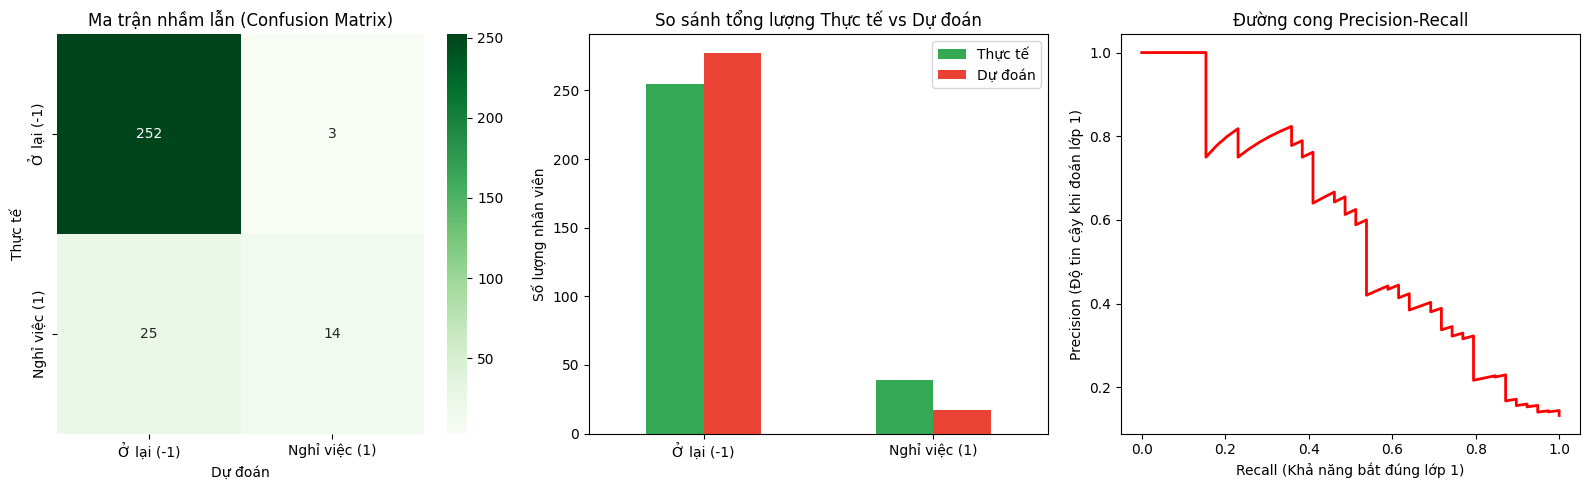

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 1. Chuẩn bị dữ liệu
X_copy_encode_2, y_copy_encode_2 = X_encode.copy(), y_encode.copy()
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_copy_encode_2, y_copy_encode_2, test_size=0.2, random_state=42)

# 2. Chuẩn hóa dữ liệu
continuous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount',
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
]
cont_cols = [col for col in continuous_data if col in X_train_2.columns]

scaler = StandardScaler()
X_train_2[cont_cols] = scaler.fit_transform(X_train_2[cont_cols])
X_test_2[cont_cols] = scaler.transform(X_test_2[cont_cols])

# 3. Huấn luyện mô hình
model_2 = SVC(kernel='linear', C=0.1, probability=True) # probability=True 
model_2.fit(X_train_2, y_train_2)

# 4. Dự đoán và lấy điểm số (decision function)
y_test_pred_2 = model_2.predict(X_test_2)
y_score_2 = model_2.decision_function(X_test_2)

# 5. Tính toán Ma trận nhầm lẫn
cm = confusion_matrix(y_test_2, y_test_pred_2)

# 6. Trực quan hóa
plt.figure(figsize=(16, 5))

# Biểu đồ 1: Heatmap Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Ở lại (-1)', 'Nghỉ việc (1)'], 
            yticklabels=['Ở lại (-1)', 'Nghỉ việc (1)'])
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')

# Biểu đồ 2: So sánh phân phối thực tế vs dự đoán
plt.subplot(1, 3, 2)
df_compare = pd.DataFrame({
    'Thực tế': [(y_test_2 == -1).sum(), (y_test_2 == 1).sum()],
    'Dự đoán': [(y_test_pred_2 == -1).sum(), (y_test_pred_2 == 1).sum()]
}, index=['Ở lại (-1)', 'Nghỉ việc (1)'])
df_compare.plot(kind='bar', ax=plt.gca(), color=['#34a853', '#ea4335'])
plt.title('So sánh tổng lượng Thực tế vs Dự đoán')
plt.xticks(rotation=0)
plt.ylabel('Số lượng nhân viên')

# Biểu đồ 3: Đường cong Precision-Recall
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test_2, y_score_2)
plt.plot(recall, precision, color='red', lw=2)
plt.xlabel('Recall (Khả năng bắt đúng lớp 1)')
plt.ylabel('Precision (Độ tin cậy khi đoán lớp 1)')
plt.title('Đường cong Precision-Recall')

plt.tight_layout()
plt.show()

Nhận xét về độ phù hợp của mô hình với bài toán:
- Mặc dù mô hình đạt độ chính xác (Accuracy) tổng thể rất cao (~90%), nhưng đối với bài toán Attrition, mô hình chưa phù hợp để triển khai thực tế vì:
    - F1-score lớp thiểu số thấp (trong trường hợp tốt nhất mới chỉ đạt 0.5): Con số này cho thấy mô hình chỉ nhận diện đúng khoảng một nửa số nhân viên thực sự nghỉ việc hoặc gặp nhiều sai lầm khi dự đoán.
    - Recall quá thấp: Ở nhiều thử nghiệm, Recall chỉ đạt 0.28 - 0.36, nghĩa là mô hình bỏ sót đến 60-70% những người có nguy cơ rời đi. Việc này có thể đánh đổi bằng cách sử dụng mô hình đã cân bằng dữ liệu tuy nhiên lại gây ra tốn kém chi phí khi có quá nhiều dự đoán sai (Precision giảm).
- Nguyên nhân:
    - Mất cân bằng dữ liệu nghiêm trọng: tập dữ liệu có quá ít mẫu "Yes" (nghỉ việc) so với "No".
    - Ngoài ra còn có thể do dữ liệu vẫn chưa đủ lớn để mô hình có thể học và phân tách tốt 2 lớp dù đã sửa dụng cả kernel tuyến tính và phi tuyến.
   